# 演習
RNNを使って、小説を執筆しましょう。
RNNのモデルを構築し、文章を自動生成します。


## テキストデータの読み込み
Google ドライブからテキストデータを読み込みます。  
このノートブックと同じフォルダに、青空文庫から取得した江戸川乱歩の「怪人二十面相」のテキストデータ"kaijin_nijumenso.txt"がありますので、パスを指定して読み込みます。

In [0]:
from google.colab import drive

drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/ai_master_course/Section_8/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'kaijin_nijumenso.txt'

# ファイルを読み込む
with open(nov_path, 'r') as f:
  nov_text = f.read()
  print(nov_text[:1000])  # 最初の1000文字のみ表示

Mounted at /content/drive/
　そのころ、東京中の町という町、家という家では、ふたり以上の人が顔をあわせさえすれば、まるでお天気のあいさつでもするように、怪人「二十面相」のうわさをしていました。
「二十面相」というのは、毎日毎日、新聞記事をにぎわしている、ふしぎな盗賊《とうぞく》のあだ名です。その賊は二十のまったくちがった顔を持っているといわれていました。つまり、変装《へんそう》がとびきりじょうずなのです。
　どんなに明るい場所で、どんなに近よってながめても、少しも変装とはわからない、まるでちがった人に見えるのだそうです。老人にも若者にも、富豪《ふごう》にも乞食《こじき》にも、学者にも無頼漢《ぶらいかん》にも、いや、女にさえも、まったくその人になりきってしまうことができるといいます。
　では、その賊のほんとうの年はいくつで、どんな顔をしているのかというと、それは、だれひとり見たことがありません。二十種もの顔を持っているけれど、そのうちの、どれがほんとうの顔なのだか、だれも知らない。いや、賊自身でも、ほんとうの顔をわすれてしまっているのかもしれません。それほど、たえずちがった顔、ちがった姿で、人の前にあらわれるのです。
　そういう変装の天才みたいな賊だものですから、警察でもこまってしまいました。いったい、どの顔を目あてに捜索したらいいのか、まるで見当がつかないからです。
　ただ、せめてものしあわせは、この盗賊は、宝石だとか、美術品だとか、美しくてめずらしくて、ひじょうに高価な品物をぬすむばかりで、現金にはあまり興味を持たないようですし、それに、人を傷つけたり殺したりする、ざんこくなふるまいは、一度もしたことがありません。血がきらいなのです。
　しかし、いくら血がきらいだからといって、悪いことをするやつのことですから、自分の身があぶないとなれば、それをのがれるためには、何をするかわかったものではありません。東京中の人が「二十面相」のうわさばかりしているというのも、じつは、こわくてしかたがないからです。
　ことに、日本にいくつという貴重な品物を持っている富豪などは、ふるえあがってこわがっていました。今までのようすで見ますと、いくら警察へたのんでも、ふせぎようのない、おそろしい賊なのですから。
　この「二十面相」には、一つのみょうなくせがありました。

## 正規表現による前処理
正規表現を使って、ルビなどを除去します。

In [0]:
import re  # 正規表現に必要なライブラリ

text = re.sub("《[^》]+》", "", nov_text) # ルビの削除
text = re.sub("［[^］]+］", "", text) # 読みの注意の削除
text = re.sub("[｜ 　]", "", text) # | と全角半角スペースの削除
print("文字数", len(text))  # len() で文字列の文字数も取得可能

文字数 110323


## 各設定
RNNの各設定です。  
ここは自由に変更しても大丈夫です。  

In [0]:
n_rnn = 10  # 時系列の数
batch_size = 128
epochs = 60
n_mid = 128  # 中間層のニューロン数

## 文字のベクトル化
各文字をone-hot表現で表し、時系列の入力データおよび正解データを作成します。  
今回はRNNの最後の時刻の出力のみ利用するので、最後の出力に対応する正解のみ必要になります。

In [23]:
import numpy as np

# インデックスと文字で辞書を作成
chars = sorted(list(set(text)))  # setで文字の重複をなくし、各文字をリストに格納する
print("文字数（重複無し）", len(chars))
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars):
    indices_char[i] = char
 
# 時系列データと、それから予測すべき文字を取り出します
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])
 
# 入力と正解をone-hot表現で表します
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1  # 正解をone-hot表現で表す
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1  # 入力をone-hot表現で表す
        
print("xの形状", x.shape)
print("tの形状", t.shape)

文字数（重複無し） 1249
xの形状 (110313, 10, 1249)
tの形状 (110313, 1249)


## モデルの構築
以下のセルに文章を生成するRNNのモデルを構築しましょう。

In [24]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

# 以下にRNNのモデルを構築する
model = Sequential()
model = Sequential()
model.add(GRU(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam")
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 128)               529152    
_________________________________________________________________
dense_3 (Dense)              (None, 1249)              161121    
Total params: 690,273
Trainable params: 690,273
Non-trainable params: 0
_________________________________________________________________
None


## 文書生成用の関数
各エポックの終了後、文章を生成するための関数を記述します。  
LambdaCallbackを使って、エポック終了時に実行される関数を設定します。

In [0]:
from keras.callbacks import LambdaCallback
 
def on_epoch_end(epoch, logs):
    print("エポック: ", epoch)

    beta = 5  # 確率分布を調整する定数
    prev_text = text[0:n_rnn]  # 入力に使う文字
    created_text = prev_text  # 生成されるテキスト
    
    print("シード: ", created_text)

    for i in range(400):
        # 入力をone-hot表現に
        x_pred = np.zeros((1, n_rnn, len(chars)))
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] = 1
        
        # 予測を行い、次の文字を得る
        y = model.predict(x_pred)
        p_power = y[0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))        
        next_char = indices_char[next_index]

        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()

# エポック終了後に実行される関数を設定
epock_end_callback= LambdaCallback(on_epoch_end=on_epoch_end)

## 学習
構築したモデルを使って、学習を行います。  
fit( )メソッドをではコールバックの設定をし、エポック終了後に関数が呼ばれるようにします。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

In [26]:
model = model
history = model.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/60





110313/110313 [==============================] - 38s 342us/step - loss: 4.7936
エポック:  0
シード:  そのころ、東京中の町
そのころ、東京中の町ののを、とののの、ののの面ののでした。
「ののは、ののののは、ののです。
「ののは、、のののののは、のののののをのが、いかのでした。
「のは、、のののをと、ののののののです。
「のと、ののののです。
「ののの、のののが、は、、のにのをと、のののうのです。
「ののに、いのです。
「ののです。
「ののは、くののをのといののです。
「ののののののなのののです。
「ののののです。
「のののは、、とののをのとした。
「とは、にのをが、、のので、とのののののにと、のと、ののののと、ののをのに、とのとののののは、のののののと、ののをののに、のののは、のののには、とのをのでした。
「ののこのでした。
「ののと、のののは、いのののののは、、ののののののを、とののに、のにのののです。
「「のです。
「れ、とのは、のののは、ののののとののです。
「、のは、をのは、、のののののは、そのをののとのです。
「、ののの

Epoch 2/60
110313/110313 [==============================] - 32s 289us/step - loss: 3.8791
エポック:  1
シード:  そのころ、東京中の町
そのころ、東京中の町のです。
「、それが、このです。
「そうないうです。
「いう、それたが、そうに、そのです。
「あ、それが、それたのです。
「いうした。
「あ、それが、それに、それに、そのです。
「あ、それないのです。
「あ、あって、そのです。
「それは、それは、それに、そうに、そうに、そのです。
「あ、そうないうに、それに、そのです。
「あ、それが、そのです。
「いうした。
「あ、それは、そのに、おいないのです。
「いう、そうに、それないのです。
「あ、それです。
「あ、そうに、それに、そのです。


## 学習の推移
誤差の推移を確認します。

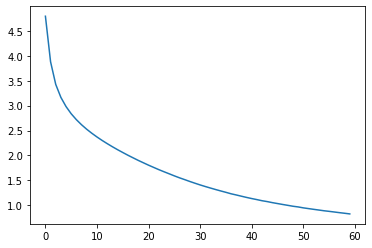

In [27]:
import matplotlib.pyplot as plt

loss = history.history['loss']

plt.plot(np.arange(len(loss)), loss)
plt.show()

# 解答例
以下は解答例です。  
どうしてもわからない時のみ、参考にしましょう。  
GRUを使った文章生成のモデルになります。

In [0]:
model = Sequential()
model.add(GRU(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam")
print(model.summary())